In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import deque
import random
import yfinance as yf
import matplotlib.pyplot as plt

# Import MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Import Sequential and LSTM from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Fetch Dow Jones 30 stocks and preprocess data
def fetch_data(tickers):
    data = {}
    models = []
    scalers = []

    for ticker in tickers:
        stock_data = yf.download(ticker, start="2021-01-01", end="2023-10-01", progress=False)
        stock_data['Return'] = stock_data['Close'].pct_change()
        data[ticker] = stock_data.dropna()

        # Scaling and reshaping for LSTM
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(stock_data[['Close']].values)

        X, y = [], []
        for i in range(5, len(scaled_data)):
            X.append(scaled_data[i-5:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X, y, epochs=50, batch_size=32)

        models.append(model)
        scalers.append(scaler)

    return data, models, scalers

# Fetch Dow Jones 30 stocks
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']  # Add the top 5 stock tickers here

# Fetch data for the specified tickers
data, lstm_models, scalers = fetch_data(tickers)

# Create a list of stock data DataFrames for the selected tickers
stock_data_list = [data[ticker] for ticker in tickers]

# Initialize lists to store cumulative returns for each stock
cumulative_returns_per_stock = [[] for _ in range(len(tickers))]

# Define the StockTradingEnv class
class StockTradingEnv:
    def __init__(self, stock_data_list, models, scalers):
        self.stock_data_list = stock_data_list
        self.models = models
        self.scalers = scalers
        self.num_stocks = len(stock_data_list)
        self.indices = [0] * self.num_stocks
        self.done = False
        self.total_rewards = [0] * self.num_stocks
        self.initial_balance = 10000.0
        self.balances = [self.initial_balance] * self.num_stocks

    def reset(self):
        self.indices = [0] * self.num_stocks
        self.done = False
        self.total_rewards = [0] * self.num_stocks
        self.balances = [self.initial_balance] * self.num_stocks
        states = []
        for i in range(self.num_stocks):
            state = self.get_state(i)
            states.append(state)
        return states

    def get_state(self, stock_index):
        state = self.stock_data_list[stock_index].iloc[self.indices[stock_index]].values
        prediction = self.predict_next_close(stock_index)
        extended_state = np.append(state, prediction)
        return extended_state

    def predict_next_close(self, stock_index):
        if 'Close' not in self.stock_data_list[stock_index].columns:
            return 0.0

        last_sequence = self.stock_data_list[stock_index]['Close'].iloc[self.indices[stock_index]-5:self.indices[stock_index]].values
        if len(last_sequence) < 5:
            return 0.0

        last_sequence_scaled = self.scalers[stock_index].transform(last_sequence.reshape(-1, 1))
        last_sequence_reshaped = np.reshape(last_sequence_scaled, (1, 5, 1))
        predicted_scaled = self.models[stock_index].predict(last_sequence_reshaped)
        predicted = self.scalers[stock_index].inverse_transform(predicted_scaled)[0, 0]
        return predicted

    def step(self, actions):
        rewards = [0] * self.num_stocks

        for stock_index in range(self.num_stocks):
            current_row = self.stock_data_list[stock_index].iloc[self.indices[stock_index]]
            next_row = self.stock_data_list[stock_index].iloc[self.indices[stock_index] + 1]
            action = actions[stock_index]

            if action == 1:  # Buy
                rewards[stock_index] = (next_row['Close'] - current_row['Open'])
            elif action == 2:  # Sell
                rewards[stock_index] = (current_row['Open'] - next_row['Close'])

            self.total_rewards[stock_index] += rewards[stock_index]
            self.indices[stock_index] += 1

            if self.indices[stock_index] >= len(self.stock_data_list[stock_index]) - 1:
                self.done = True
                self.indices[stock_index] = 0

            next_state = self.get_state(stock_index)
            prediction = self.predict_next_close(stock_index)
            extended_next_state = np.append(next_state, prediction)
            self.balances[stock_index] += rewards[stock_index]

            # Update cumulative returns for each stock
            cumulative_returns_per_stock[stock_index].append(self.total_rewards[stock_index])

        return self.done, self.total_rewards, self.balances


# Define the DQNAgent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=1000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state_tensor = torch.FloatTensor(state).float()
        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        criterion = nn.MSELoss()
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).float()
            next_state_tensor = torch.FloatTensor(next_state).float()

            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state_tensor)).item()
            else:
                target = reward
            target_tensor = torch.tensor([target], dtype=torch.float32)

            current_value = self.model(state_tensor).squeeze()[action].unsqueeze(0)
            loss = criterion(current_value, target_tensor)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Create the StockTradingEnv instance with multiple stocks
env = StockTradingEnv(stock_data_list, lstm_models, scalers)
state_size = len(env.reset()[0])
action_size = 3  # Change this based on your action space

# Create the DQNAgent instance
agent = DQNAgent(state_size, action_size)

# Training loop (as previously defined)

# Training loop
EPISODES = 20
results = []

# Initialize an empty list to store cumulative rewards over episodes
cumulative_rewards = []

for e in range(EPISODES):
    state = env.reset()
    done = False
    while not done:
        actions = [agent.act(state[i]) for i in range(len(state))]
        done, rewards, balances = env.step(actions)

        # Update cumulative returns for each stock
        for i in range(len(tickers)):
            cumulative_returns_per_stock[i].append(env.total_rewards[i])

        state = env.reset() if done else state  # Replace next_state with state
        if done:
            cumulative_rewards.append(sum(rewards))
            print(f"episode: {e+1}/{EPISODES}, total reward: {sum(rewards)}")
            results.append({
                "Episode": e+1,
                "Total Reward": sum(rewards)
            })




Epoch 1/50
22/22 [==============================] - 8s 5ms/step - loss: 0.0816
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 8/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 9/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 10/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 11/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 12/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 13/50
22/22 [==============================

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
episode: 20/20, total reward: -18.83404541015625


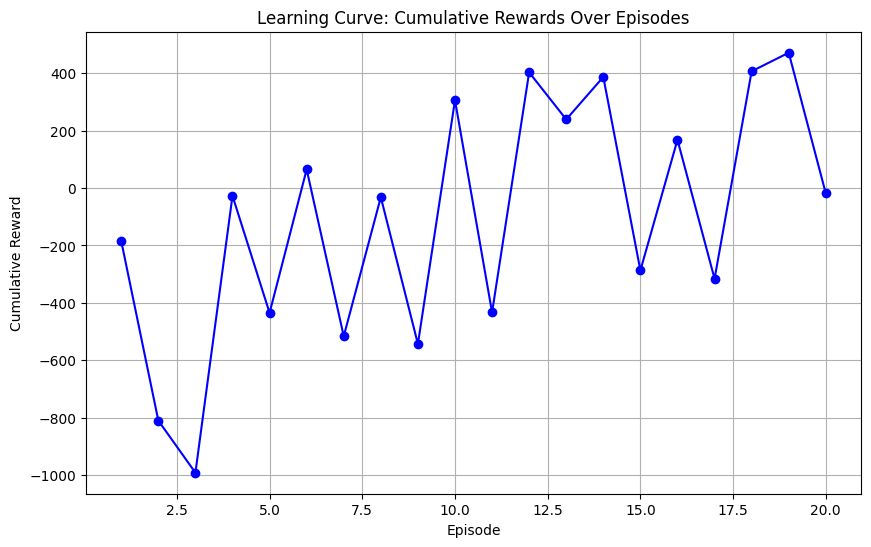

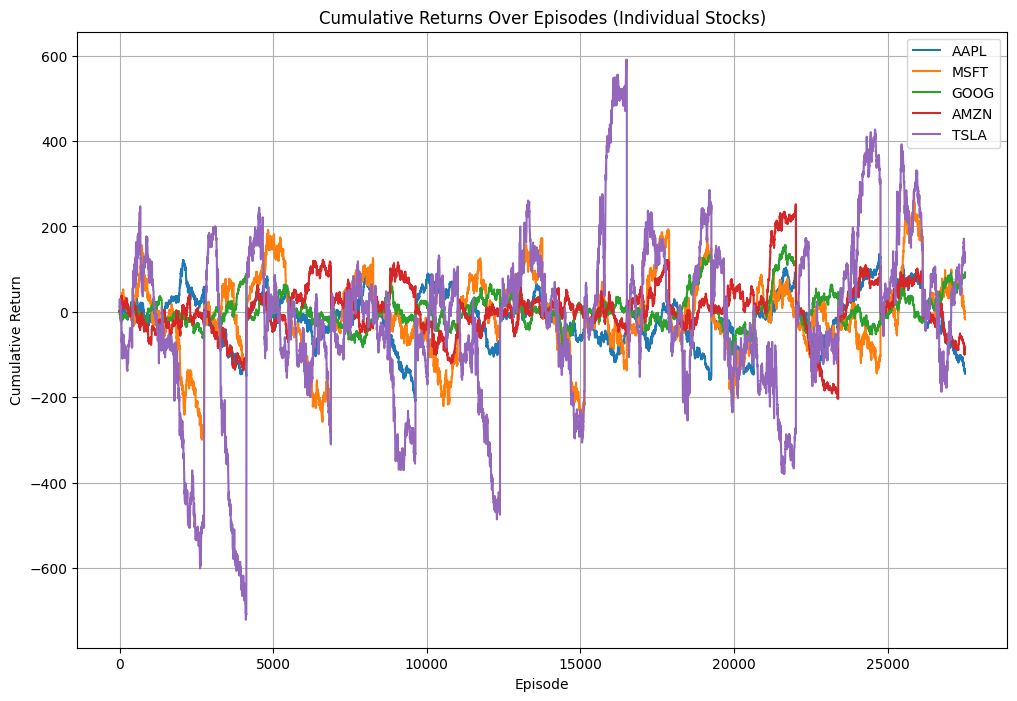

In [2]:
# Plot the learning curve (cumulative rewards over episodes)
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPISODES+1), cumulative_rewards, marker='o', linestyle='-', color='b')
plt.title('Learning Curve: Cumulative Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()

# Plot cumulative returns for each individual stock
plt.figure(figsize=(12, 8))
for i in range(len(tickers)):
    plt.plot(range(1, len(cumulative_returns_per_stock[i]) + 1), cumulative_returns_per_stock[i], label=tickers[i])

plt.title('Cumulative Returns Over Episodes (Individual Stocks)')
plt.xlabel('Episode')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


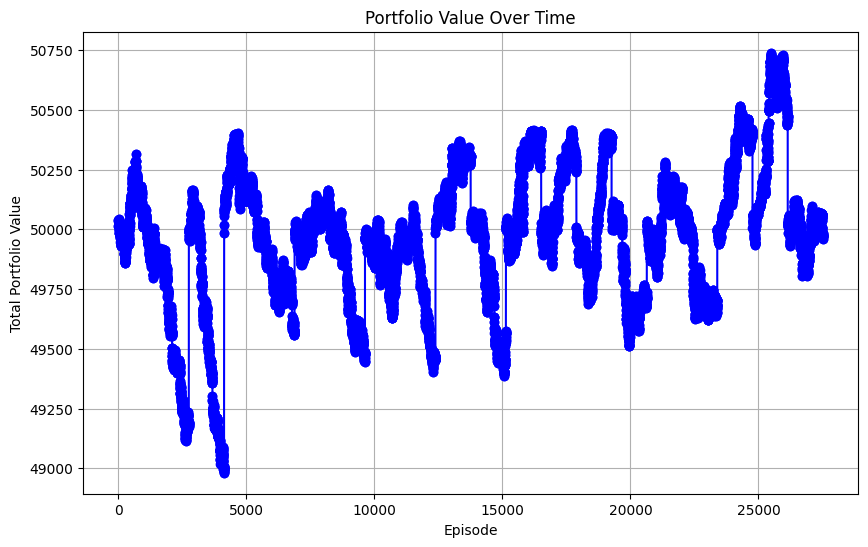

In [5]:
import matplotlib.pyplot as plt

# Assuming cumulative_returns_per_stock is a list of lists,
# where each inner list contains the cumulative returns of a specific stock over time.
# Example: [[0, 100, 200, ...], [0, -100, -200, ...], ...]

initial_investment_per_stock = 10000.00  # Initial investment for each stock
num_episodes = len(cumulative_returns_per_stock[0])

# Calculate the total value of each stock at each time step
total_values_per_stock = [[initial_investment_per_stock + return_amount for return_amount in stock_returns]
                          for stock_returns in cumulative_returns_per_stock]

# Calculate the total portfolio value at each time step
total_portfolio_values = [sum(stock_values[i] for stock_values in total_values_per_stock) for i in range(num_episodes)]

# Plotting the total portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes + 1), total_portfolio_values, marker='o', linestyle='-', color='b')
plt.title('Portfolio Value Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Portfolio Value')
plt.grid(True)
plt.show()
